In [ ]:
#%pip install tensorflow numpy matplotlib
%pip install tensorflow numpy matplotlib scikit-learn





Epoch 1/50
25/25 [==============================] - 1s 8ms/step - loss: 0.1784 - val_loss: 0.1487
Epoch 2/50
25/25 [==============================] - 0s 2ms/step - loss: 0.1313 - val_loss: 0.1271
Epoch 3/50
25/25 [==============================] - 0s 2ms/step - loss: 0.1186 - val_loss: 0.1176
Epoch 4/50
25/25 [==============================] - 0s 2ms/step - loss: 0.1116 - val_loss: 0.1117
Epoch 5/50
25/25 [==============================] - 0s 2ms/step - loss: 0.1065 - val_loss: 0.1075
Epoch 6/50
25/25 [==============================] - 0s 2ms/step - loss: 0.1034 - val_loss: 0.1064
Epoch 7/50
25/25 [==============================] - 0s 2ms/step - loss: 0.1007 - val_loss: 0.1044
Epoch 8/50
25/25 [==============================] - 0s 2ms/step - loss: 0.0990 - val_loss: 0.1023
Epoch 9/50
25/25 [==============================] - 0s 2ms/step - loss: 0.0986 - val_loss: 0.1005
Epoch 10/50
25/25 [==============================] - 0s 2ms/step - loss: 0.0972 - val_loss: 0.0994
Epoch 11/50
25/2

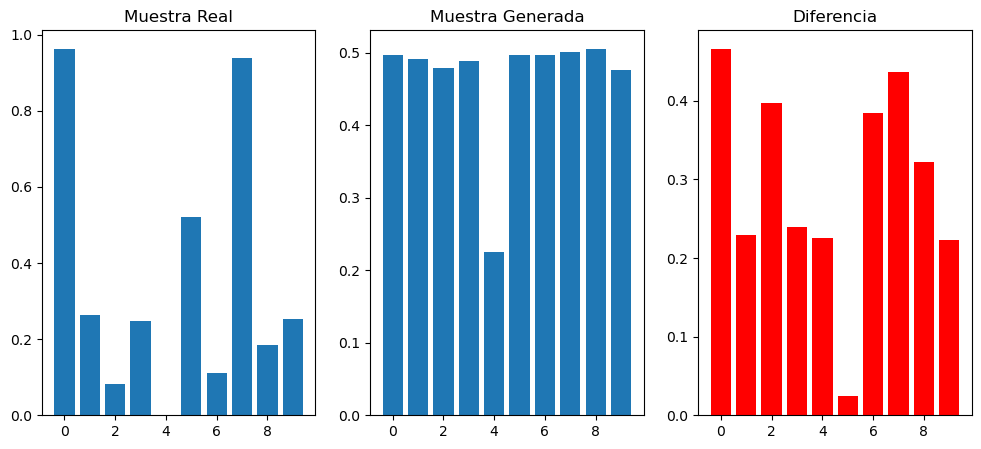

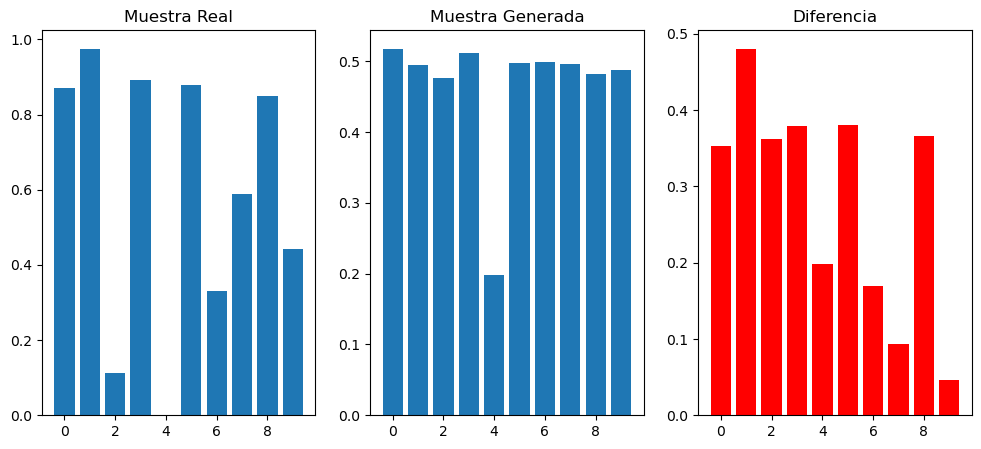

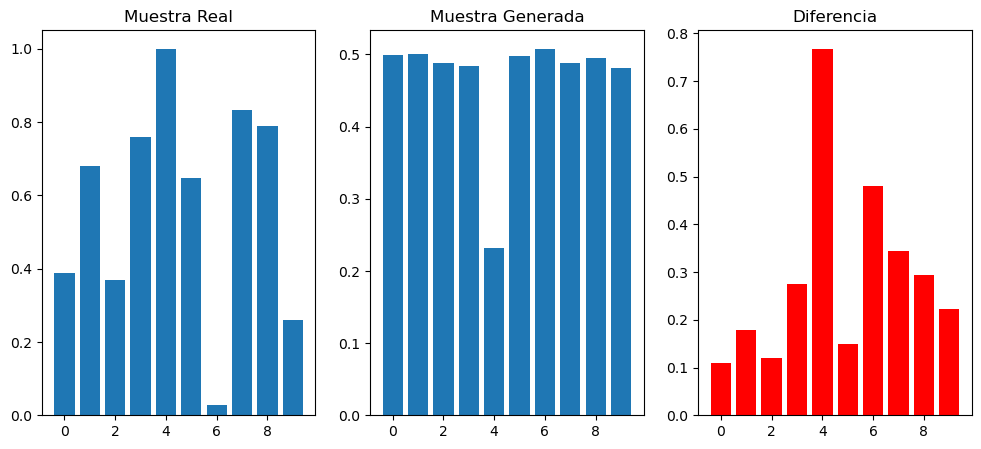

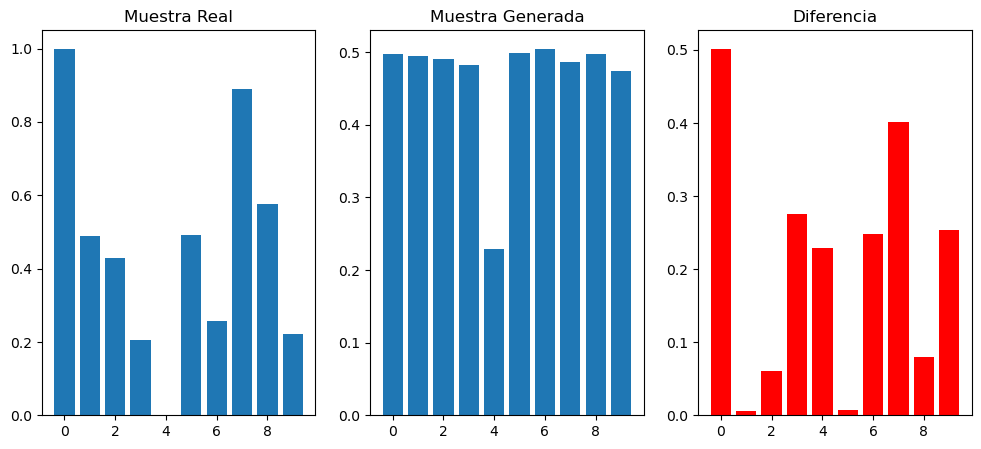

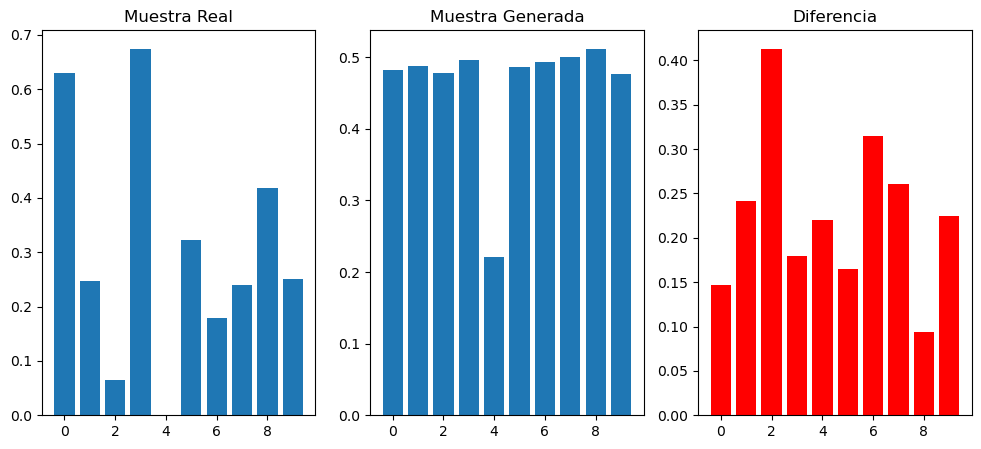

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Generar datos de ejemplo relacionados con enfermedades cardíacas
np.random.seed(42)
num_samples = 1000
input_dim = 10

def generate_medical_data(num_samples, input_dim):
    age = np.random.randint(25, 80, size=num_samples)
    cholesterol = np.random.uniform(120, 300, size=num_samples)
    blood_pressure = np.random.uniform(90, 180, size=num_samples)
    heart_rate = np.random.uniform(60, 100, size=num_samples)
    diabetes = np.random.choice([0, 1], size=num_samples, p=[0.8, 0.2])

    # Combinar características en una matriz de entrada
    X = np.column_stack((age, cholesterol, blood_pressure, heart_rate, diabetes, np.random.rand(num_samples, input_dim - 5)))

    return X

# Generar datos de entrada y normalizarlos
X_real = generate_medical_data(num_samples, input_dim)
scaler = MinMaxScaler()
X_real = scaler.fit_transform(X_real)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(X_real, test_size=0.2, random_state=42)

# Definir la arquitectura del Variational Autoencoder (VAE)
def build_medical_vae(input_dim, latent_dim):
    # Codificador
    inputs = Input(shape=(input_dim,))
    h = Dense(16, activation='relu')(inputs)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)

    # Función de muestreo
    def sampling(args):
        z_mean, z_log_var = args
        batch = K.shape(z_mean)[0]
        dim = K.int_shape(z_mean)[1]
        epsilon = K.random_normal(shape=(batch, dim))
        return z_mean + K.exp(0.5 * z_log_var) * epsilon

    # Utilizar la función de muestreo para obtener la capa de entrada al decodificador
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # Decodificador
    decoder_h = Dense(16, activation='relu')
    decoder_mean = Dense(input_dim, activation='sigmoid')
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)

    # Construir el modelo VAE
    vae = Model(inputs, x_decoded_mean)

    # Definir la pérdida VAE
    xent_loss = MeanSquaredError()(inputs, x_decoded_mean)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)

    vae.add_loss(vae_loss)
    vae.compile(optimizer=Adam(learning_rate=0.001))

    return vae

# Construir y entrenar el VAE con datos médicos reales
latent_dim = 2  # Reducido para facilitar la visualización
medical_vae = build_medical_vae(input_dim, latent_dim)
medical_vae.fit(X_train, epochs=50, batch_size=32, validation_data=(X_test, None))

# Generar pacientes virtuales utilizando el VAE entrenado
num_generated_samples = 5
generated_samples = medical_vae.predict(X_test[:num_generated_samples])

# Visualizar las muestras generadas
for i in range(num_generated_samples):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 3, 1)
    plt.title('Muestra Real')
    plt.bar(range(input_dim), X_test[i])
    
    plt.subplot(1, 3, 2)
    plt.title('Muestra Generada')
    plt.bar(range(input_dim), generated_samples[i])
    
    plt.subplot(1, 3, 3)
    plt.title('Diferencia')
    plt.bar(range(input_dim), np.abs(X_test[i] - generated_samples[i]), color='red')
    
    plt.show()


In [3]:
##GAN
%pip install tensorflow numpy matplotlib

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Generar datos de ejemplo relacionados con enfermedades cardíacas
np.random.seed(42)
num_samples = 1000
input_dim = 10

# Crear un conjunto de datos ficticio con características médicas
def generate_medical_data(num_samples, input_dim):
    age = np.random.randint(25, 80, size=num_samples)
    cholesterol = np.random.uniform(120, 300, size=num_samples)
    blood_pressure = np.random.uniform(90, 180, size=num_samples)
    heart_rate = np.random.uniform(60, 100, size=num_samples)
    diabetes = np.random.choice([0, 1], size=num_samples, p=[0.8, 0.2])

    # Combinar características en una matriz de entrada
    X = np.column_stack((age, cholesterol, blood_pressure, heart_rate, diabetes, np.random.rand(num_samples, input_dim - 5)))

    return X

# Generar datos de entrada y normalizarlos
X_real = generate_medical_data(num_samples, input_dim)
scaler = MinMaxScaler()
X_real = scaler.fit_transform(X_real)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(X_real, test_size=0.2, random_state=42)

# Definir la arquitectura de la GAN
def build_gan(input_dim, latent_dim):
    # Generador
    generator = Sequential([
        Dense(16, input_dim=latent_dim, activation='relu'),
        Dense(input_dim, activation='sigmoid')
    ])

    # Discriminador
    discriminator = Sequential([
        Dense(16, input_dim=input_dim, activation=LeakyReLU(alpha=0.2)),
        Dense(1, activation='sigmoid')
    ])

    # Construir y compilar el modelo GAN
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(gan_input, gan_output)
    
    # Compilar el modelo GAN
    gan.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

    # Compilar el modelo discriminador (separadamente)
    discriminator.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')
    
    return generator, discriminator, gan

# Construir y entrenar la GAN con datos médicos reales
latent_dim = 10
generator, discriminator, gan = build_gan(input_dim, latent_dim)

epochs = 5000
batch_size = 32

for epoch in range(epochs):
    # Generar muestras aleatorias en el espacio latente
    noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
    generated_samples = generator.predict(noise)

    # Seleccionar un lote aleatorio de muestras reales
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_samples = X_train[idx]

    # Etiquetas para el entrenamiento del discriminador
    y_real = np.ones((batch_size, 1))
    y_fake = np.zeros((batch_size, 1))

    # Entrenar el discriminador
    d_loss_real = discriminator.train_on_batch(real_samples, y_real)
    d_loss_fake = discriminator.train_on_batch(generated_samples, y_fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Generar muestras aleatorias en el espacio latente
    noise = np.random.normal(0, 1, size=(batch_size, latent_dim))

    # Etiquetas para el entrenamiento del generador (engañar al discriminador)
    y_gen = np.ones((batch_size, 1))

    # Entrenar el generador a través de la GAN (el discriminador está congelado)
    g_loss = gan.train_on_batch(noise, y_gen)

    # Imprimir el progreso
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, D Loss: {d_loss}, G Loss: {g_loss}")


Note: you may need to restart the kernel to use updated packages.
1/1 [==============================] - 0s 36ms/step

Epoch 0, D Loss: 0.7010751962661743, G Loss: 0.6379981637001038
1/1 [==============================] - 0s 15ms/step
Epoch 500, D Loss: 0.9245820045471191, G Loss: 0.3589716851711273
1/1 [==============================] - 0s 14ms/step
Epoch 1000, D Loss: 0.9564073085784912, G Loss: 0.3491978049278259
1/1 [==============================] - 0s 14ms/step
Epoch 1500, D Loss: 0.9455968141555786, G Loss: 0.3477279543876648
1/1 [==============================] - 0s 18ms/step
Epoch 2000, D Loss: 0.9463708400726318, G Loss: 0.34716472029685974
1/1 [==============================] - 0s 14ms/step
Epoch 2500, D Loss: 0.9535143375396729, G Loss: 0.3468989133834839
1/1 [==============================] - 0s 14ms/step
Epoch 3000, D Loss: 0.9376232028007507, G Loss: 0.34685930609703064
1/1 [==============================] - 0s 16ms/step
Epoch 3500, D Loss: 0.9482628703117371, G Loss: 0.

Epoch 1/100
20/20 [==============================] - 1s 6ms/step - loss: 0.3208 - val_loss: 0.2132
Epoch 2/100
20/20 [==============================] - 0s 2ms/step - loss: 0.1399 - val_loss: 0.0756
Epoch 3/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0391 - val_loss: 0.0192
Epoch 4/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0133 - val_loss: 0.0104
Epoch 5/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.0080
Epoch 6/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0059 - val_loss: 0.0062
Epoch 7/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0046 - val_loss: 0.0050
Epoch 8/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0041
Epoch 9/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 10/100
20/20 [==============================] - 0s 2ms/step - loss: 0.0025 - val_loss: 0.0031
Epoch 11/

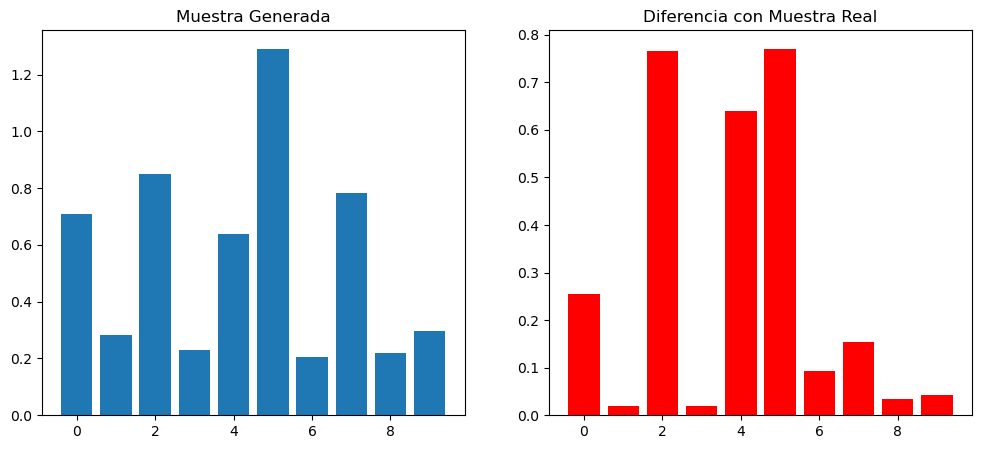

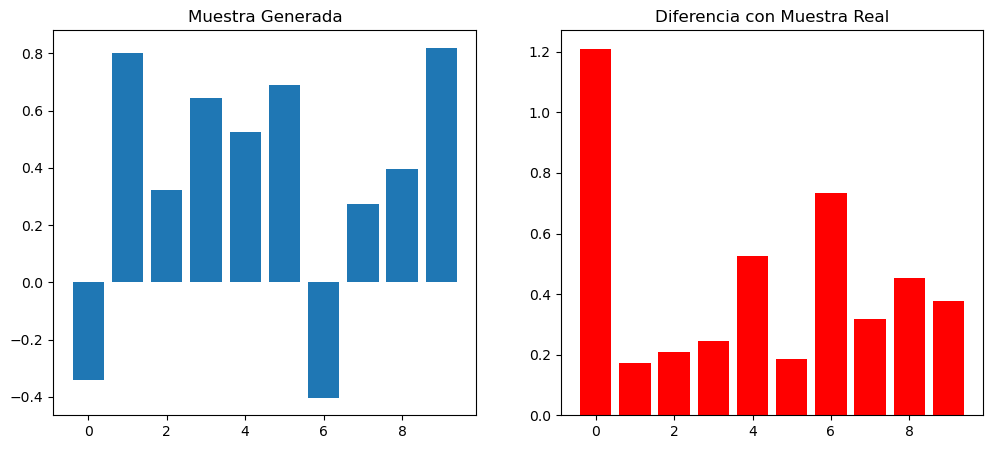

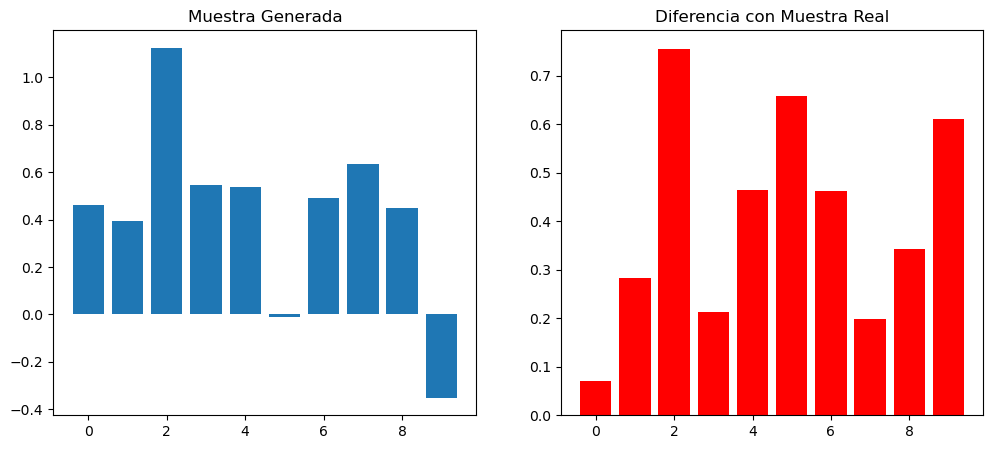

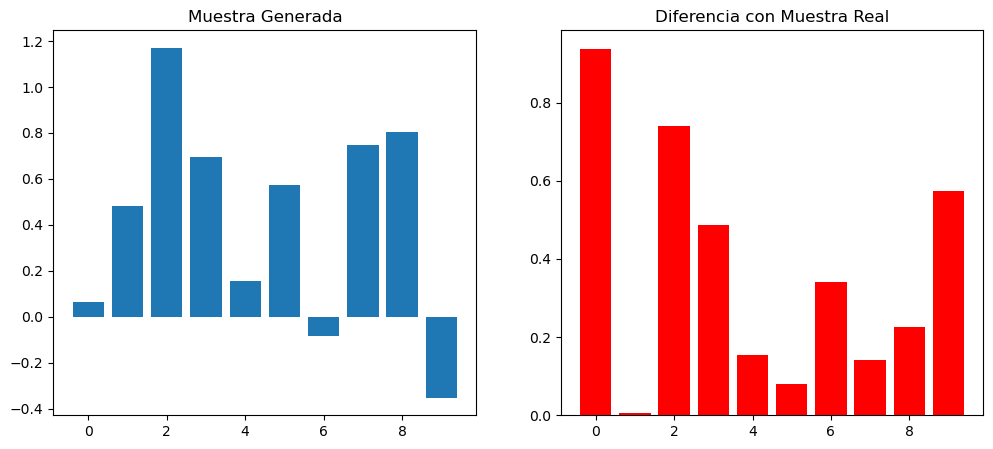

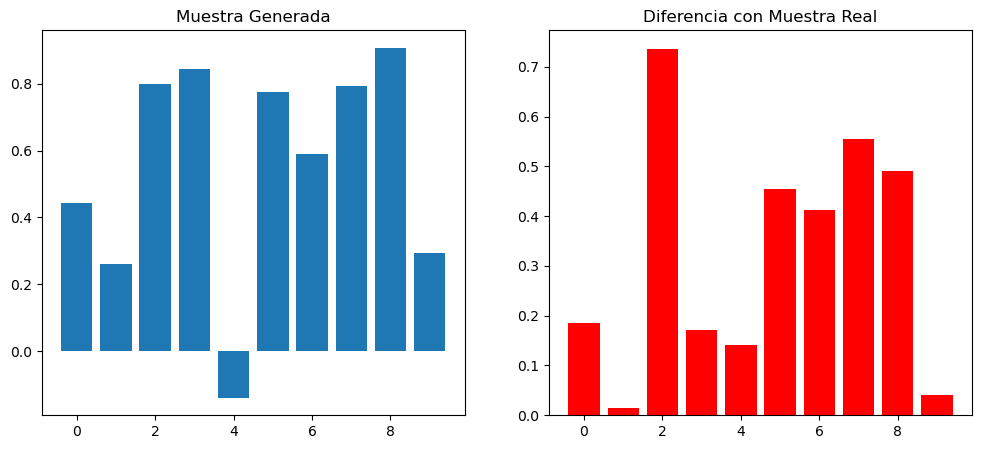

In [10]:
##DIfusion

#%pip install numpy matplotlib tensorflow tensorflow-probability scikit-learn


import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

tfd = tfp.distributions

# Generar datos de ejemplo relacionados con enfermedades cardíacas
np.random.seed(42)
num_samples = 1000
input_dim = 10

# Crear un conjunto de datos ficticio con características médicas
def generate_medical_data(num_samples, input_dim):
    age = np.random.randint(25, 80, size=num_samples)
    cholesterol = np.random.uniform(120, 300, size=num_samples)
    blood_pressure = np.random.uniform(90, 180, size=num_samples)
    heart_rate = np.random.uniform(60, 100, size=num_samples)
    diabetes = np.random.choice([0, 1], size=num_samples, p=[0.8, 0.2])

    # Combinar características en una matriz de entrada
    X = np.column_stack((age, cholesterol, blood_pressure, heart_rate, diabetes, np.random.rand(num_samples, input_dim - 5)))

    return X

# Generar datos de entrada y normalizarlos
X_real = generate_medical_data(num_samples, input_dim)
scaler = MinMaxScaler()
X_real = scaler.fit_transform(X_real)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(X_real, test_size=0.2, random_state=42)

# Escalar los datos entre -1 y 1
X_train_scaled = 2 * X_train - 1

# Definir la arquitectura de la GAN
def build_diffusion_model(input_dim):
    # Entrada del modelo
    input_layer = Input(shape=(input_dim,))

    # Capa oculta
    x = Dense(128, activation='relu')(input_layer)
    x = Dense(128, activation='relu')(x)

    # Parámetros de la distribución (media y log(desviación estándar))
    output_layer = Dense(input_dim)(x)


    # Construir el modelo
    diffusion_model = Model(inputs=input_layer, outputs=output_layer)

    return diffusion_model

# Construir y compilar el modelo de difusión
input_dim = 10
diffusion_model = build_diffusion_model(input_dim)
diffusion_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Entrenar el modelo de difusión
diffusion_model.fit(X_train_scaled, X_train_scaled, epochs=100, batch_size=32, validation_split=0.2)

# Función para muestrear del modelo de difusión
def sample_from_diffusion_model(model, num_samples):
    z = tf.random.normal(shape=(num_samples, input_dim))
    samples = model.predict(z)
    return samples

# Generar pacientes virtuales mediante el modelo de difusión
num_generated_samples = 5
generated_samples_scaled = sample_from_diffusion_model(diffusion_model, num_generated_samples)

# Desescalar las muestras generadas para comparar con los datos reales
generated_samples = 0.5 * (generated_samples_scaled + 1)

# Visualizar las muestras generadas
for i in range(num_generated_samples):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.title('Muestra Generada')
    plt.bar(range(input_dim), generated_samples[i])
    
    plt.subplot(1, 2, 2)
    plt.title('Diferencia con Muestra Real')
    plt.bar(range(input_dim), np.abs(X_test[i] - generated_samples[i]), color='red')
    
    plt.show()


In [11]:
## NN
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Generar datos de ejemplo relacionados con enfermedades cardíacas
np.random.seed(42)
num_samples = 1000
input_dim = 10

def generate_medical_data(num_samples, input_dim):
    age = np.random.randint(25, 80, size=num_samples)
    cholesterol = np.random.uniform(120, 300, size=num_samples)
    blood_pressure = np.random.uniform(90, 180, size=num_samples)
    heart_rate = np.random.uniform(60, 100, size=num_samples)
    diabetes = np.random.choice([0, 1], size=num_samples, p=[0.8, 0.2])

    # Combinar características en una matriz de entrada
    X = np.column_stack((age, cholesterol, blood_pressure, heart_rate, np.random.rand(num_samples, input_dim - 4)))

    return X, diabetes

# Generar datos de entrada y salida
X, y = generate_medical_data(num_samples, input_dim)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los datos
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Construir un modelo de red neuronal más complejo
model = Sequential()
model.add(Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Evaluar el rendimiento del modelo en el conjunto de prueba
accuracy = model.evaluate(X_test, y_test)[1]
print(f"Accuracy on test set: {accuracy}")

# Realizar predicciones en el conjunto de prueba
predictions = model.predict(X_test[:5])
print("Sample Predictions:")
for i in range(5):
    print(f"Actual: {y_test[i]}, Predicted: {predictions[i][0]:.4f}")


Epoch 1/50
25/25 [==============================] - 1s 8ms/step - loss: 1.8750 - accuracy: 0.7713 - val_loss: 1.6143 - val_accuracy: 0.8300
Epoch 2/50
25/25 [==============================] - 0s 2ms/step - loss: 1.5238 - accuracy: 0.8025 - val_loss: 1.3235 - val_accuracy: 0.8300
Epoch 3/50
25/25 [==============================] - 0s 2ms/step - loss: 1.2715 - accuracy: 0.8075 - val_loss: 1.1221 - val_accuracy: 0.8300
Epoch 4/50
25/25 [==============================] - 0s 2ms/step - loss: 1.1008 - accuracy: 0.8075 - val_loss: 0.9700 - val_accuracy: 0.8300
Epoch 5/50
25/25 [==============================] - 0s 2ms/step - loss: 0.9704 - accuracy: 0.8075 - val_loss: 0.8548 - val_accuracy: 0.8300
Epoch 6/50
25/25 [==============================] - 0s 2ms/step - loss: 0.8906 - accuracy: 0.8075 - val_loss: 0.7810 - val_accuracy: 0.8300
Epoch 7/50
25/25 [==============================] - 0s 2ms/step - loss: 0.7954 - accuracy: 0.8075 - val_loss: 0.7109 - val_accuracy: 0.8300
Epoch 8/50
25/25 [==

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

tfd = tfp.distributions

# Generar datos de ejemplo relacionados con enfermedades cardíacas
np.random.seed(42)
num_samples = 1000
input_dim = 10

# Crear un conjunto de datos ficticio con características médicas
def generate_medical_data(num_samples, input_dim):
    age = np.random.randint(25, 80, size=num_samples)
    cholesterol = np.random.uniform(120, 300, size=num_samples)
    blood_pressure = np.random.uniform(90, 180, size=num_samples)
    heart_rate = np.random.uniform(60, 100, size=num_samples)
    diabetes = np.random.choice([0, 1], size=num_samples, p=[0.8, 0.2])

    # Combinar características en una matriz de entrada
    X = np.column_stack((age, cholesterol, blood_pressure, heart_rate, diabetes, np.random.rand(num_samples, input_dim - 5)))

    return X

# Generar datos de entrada y normalizarlos
X_real = generate_medical_data(num_samples, input_dim)
scaler = MinMaxScaler()
X_real = scaler.fit_transform(X_real)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(X_real, test_size=0.2, random_state=42)

# Escalar los datos entre -1 y 1
X_train_scaled = 2 * X_train - 1

# Construir un modelo de regresión bayesiana con TensorFlow Probability
def build_bayesian_model(input_dim):
    # Entrada del modelo
    input_layer = Input(shape=(input_dim,))

    # Capas ocultas
    x = Dense(128, activation='relu')(input_layer)
    x = Dense(128, activation='relu')(x)

    # Parámetros de la distribución posterior
    loc = Dense(input_dim)(x)
    scale = Dense(input_dim, activation='softplus')(x)

    # Crear la distribución posterior
    posterior = tfd.Independent(tfd.Normal(loc=loc, scale=scale), reinterpreted_batch_ndims=1)

    # Sampleo de la distribución posterior
    output_layer = Lambda(lambda x: x.sample())(posterior)

    # Construir el modelo
    bayesian_model = Model(inputs=input_layer, outputs=output_layer)

    return bayesian_model, posterior

# Construir y compilar el modelo bayesiano
input_dim = 10
bayesian_model, posterior = build_bayesian_model(input_dim)
bayesian_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Entrenar el modelo bayesiano
bayesian_model.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=32, validation_split=0.2)

# Realizar predicciones en el conjunto de prueba
predictions = bayesian_model.predict(X_test[:5])

# Visualizar las predicciones y las muestras de la distribución posterior
for i in range(5):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.title('Predicción')
    plt.bar(range(input_dim), predictions[i])
    
    plt.subplot(1, 2, 2)
    plt.title('Muestra de la Distribución Posterior')
    plt.bar(range(input_dim), posterior.sample()[i].numpy())
    
    plt.show()


TypeError: Exception encountered when calling layer 'lambda_6' (type Lambda).

Dimension value must be integer or None or have an __index__ method, got value '<attribute 'shape' of 'numpy.generic' objects>' with type '<class 'getset_descriptor'>'

Call arguments received by layer 'lambda_6' (type Lambda):
  • inputs=<tfp.distributions.Independent 'IndependentNormal' batch_shape=[?] event_shape=[10] dtype=float32>
  • mask=None
  • training=None

In [6]:
%pip install keras tensorflow.keras.layers tensorflow.keras.models

import numpy as np
import keras
from tensorflow import keras 
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

tfd = tfp.distributions

# Generar datos de ejemplo relacionados con enfermedades cardíacas
np.random.seed(42)
num_samples = 1000
input_dim = 10

# Crear un conjunto de datos ficticio con características médicas
def generate_medical_data(num_samples, input_dim):
    age = np.random.randint(25, 80, size=num_samples)
    cholesterol = np.random.uniform(120, 300, size=num_samples)
    blood_pressure = np.random.uniform(90, 180, size=num_samples)
    heart_rate = np.random.uniform(60, 100, size=num_samples)
    diabetes = np.random.choice([0, 1], size=num_samples, p=[0.8, 0.2])

    # Combinar características en una matriz de entrada
    X = np.column_stack((age, cholesterol, blood_pressure, heart_rate, diabetes, np.random.rand(num_samples, input_dim - 5)))

    return X

# Generar datos de entrada y normalizarlos
X_real = generate_medical_data(num_samples, input_dim)
scaler = MinMaxScaler()
X_real = scaler.fit_transform(X_real)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(X_real, test_size=0.2, random_state=42)

# Escalar los datos entre -1 y 1
X_train_scaled = 2 * X_train - 1

# Construir un modelo de regresión bayesiana con TensorFlow Probability
def build_bayesian_model(input_dim):
    # Entrada del modelo
    input_layer = Input(shape=(input_dim,))

    # Capas ocultas
    x = Dense(128, activation='relu')(input_layer)
    x = Dense(128, activation='relu')(x)

    # Parámetros de la distribución posterior
    loc = Dense(input_dim)(x)
    scale = Dense(input_dim, activation='softplus')(x)

    # Crear la distribución posterior
    posterior = tfd.Independent(tfd.Normal(loc=loc, scale=scale), reinterpreted_batch_ndims=1)

    # Sampleo de la distribución posterior usando una función Lambda
    sampling_layer = Lambda(lambda x: x.sample())  # Usaremos una función Lambda separada
    output_layer = sampling_layer(posterior)

    # Construir el modelo
    bayesian_model = Model(inputs=input_layer, outputs=output_layer)

    return bayesian_model, posterior

# Construir y compilar el modelo bayesiano
input_dim = 10
bayesian_model, posterior = build_bayesian_model(input_dim)
bayesian_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# Entrenar el modelo bayesiano
bayesian_model.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=32, validation_split=0.2)

# Realizar predicciones en el conjunto de prueba
predictions = bayesian_model.predict(X_test[:5])

# Visualizar las predicciones y las muestras de la distribución posterior
for i in range(5):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.title('Predicción')
    plt.bar(range(input_dim), predictions[i])
    
    plt.subplot(1, 2, 2)
    plt.title('Muestra de la Distribución Posterior')
    plt.bar(range(input_dim), posterior.sample()[i].numpy())
    
    plt.show()


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow.keras.layers (from versions: none)
ERROR: No matching distribution found for tensorflow.keras.layers


TypeError: Exception encountered when calling layer 'lambda_5' (type Lambda).

Dimension value must be integer or None or have an __index__ method, got value '<attribute 'shape' of 'numpy.generic' objects>' with type '<class 'getset_descriptor'>'

Call arguments received by layer 'lambda_5' (type Lambda):
  • inputs=<tfp.distributions.Independent 'IndependentNormal' batch_shape=[?] event_shape=[10] dtype=float32>
  • mask=None
  • training=None